In [1]:
# !pip install tf_keras tensorflow tensorflow-recommenders tensorflow-datasets scann

In [2]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
from typing import Dict, Text

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

2024-08-25 20:11:46.969082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 20:11:46.986596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 20:11:46.991504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 20:11:47.006942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 20:11:48.128971: W tensorflow/compiler/tf2

## Preprocess

### Download Datasets

In [4]:
# Download the dataset and cache them as `tfrecord`

ratings_dataset, ratings_dataset_info = tfds.load(
    # Options: '25m-ratings', 'latest-small-ratings', '100k-ratings', '1m-ratings', '20m-ratings'
    name = 'movielens/100k-ratings',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Ratings count:", ratings_dataset.__len__().numpy())

movies_dataset, movies_dataset_info = tfds.load(
    # Options: '25m-movies', 'latest-small-movies', '100k-movies', '1m-movies', '20m-movies'
    name = 'movielens/100k-movies',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Movies count:", movies_dataset.__len__().numpy())

I0000 00:00:1724604109.916386  348353 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724604109.949535  348353 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724604109.949651  348353 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724604109.953145  348353 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724604109.953243  348353 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Ratings count: 100000
Movies count: 1682


### Feature Selection

In [5]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

### Dataset Splitting

In [6]:
# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # The new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size = 100_000,
    # The random seed used to create the distribution.
    seed = RANDOM_STATE,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration = False
)

# Split dataset randomly (80% for training and 20% for validation)
trainset_size: int  = 0.01 * ratings_dataset.__len__().numpy()

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_validset = ratings_dataset_shuffled.skip(trainset_size)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 1000
validset_size: 99000


### Categorical Features to Embeddings

In [7]:
USER_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

user_ids            = ['1', '124', 'xxx']
user_ids_mappings   = list(user_id_lookup_layer(user_ids).numpy())
print(f"Lookups for user_ids {user_ids} -> {user_ids_mappings}")


user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = user_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = USER_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

user_ids_embeddings = user_id_model(tf.convert_to_tensor(user_ids))
print(f"Embeddings for user_ids {user_ids} -> {user_ids_embeddings}")

Lookups for user_ids ['1', '124', 'xxx'] -> [129, 0, 0]
Embeddings for user_ids ['1', '124', 'xxx'] -> [[ 0.02157599  0.03845355  0.02531253 -0.00665054  0.01891593  0.0359735
  -0.04568642 -0.00346562 -0.0250244   0.02799756 -0.04900973 -0.01800008
   0.04019803  0.047699    0.02813366  0.01631031  0.03325794  0.02740519
   0.04228738 -0.0264335  -0.01430427 -0.01527144  0.00829244  0.01741935
   0.00429133  0.00947125 -0.00800788  0.00694861  0.01812929  0.03652394
   0.01736038  0.01561096]
 [-0.00376282  0.03021562 -0.00813886  0.03519571 -0.03867735  0.00975079
   0.03689036 -0.01518493 -0.01735563 -0.00047152 -0.02052903  0.006575
   0.02475509  0.04920254  0.01788057  0.029363    0.0348642  -0.04382583
   0.04426566  0.02311984 -0.02241751 -0.02705942 -0.0272841  -0.01236873
  -0.03810675  0.00399597 -0.02729565 -0.01296519 -0.02174505 -0.02007623
  -0.04867278  0.01843028]
 [-0.00376282  0.03021562 -0.00813886  0.03519571 -0.03867735  0.00975079
   0.03689036 -0.01518493 -0.017

In [8]:
MOVIE_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
movie_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

movie_ids            = ['1', '124', 'xxx']
movie_ids_mappings   = list(movie_id_lookup_layer(['1', '12', '100', 'xxx']).numpy())
print(f"Lookups for movie_ids {movie_ids} -> {movie_ids_mappings}")


movie_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = movie_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = MOVIE_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (movie_id) in and yields embeddings
movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

movie_ids_embeddings = movie_id_model(tf.convert_to_tensor(movie_ids))
print(f"Embeddings for movie_ids {movie_ids} -> {movie_ids_embeddings}")

Lookups for movie_ids ['1', '124', 'xxx'] -> [22, 0, 7, 0]
Embeddings for movie_ids ['1', '124', 'xxx'] -> [[-0.00585949 -0.0117756  -0.02662273 -0.02278975 -0.03739022  0.03718842
   0.01714453  0.00128814 -0.02946158  0.04312271 -0.03143165  0.02789155
  -0.00559963 -0.01929173  0.00221521 -0.00275413  0.03885351  0.01895661
   0.02871262 -0.04235848  0.03329677 -0.03617498 -0.01388995  0.02754984
  -0.01230433  0.00433166  0.01579719  0.01488382 -0.04688708 -0.03174156
   0.03927864 -0.00581876]
 [ 0.01205153 -0.02122881 -0.02217537  0.01941327 -0.01518258  0.0087167
  -0.00233378 -0.0023625   0.03385086  0.04795879  0.04245624  0.03905186
  -0.0414447  -0.00450816 -0.01689785 -0.0400521  -0.01154269  0.0047242
  -0.01355481 -0.02615735 -0.03308912  0.03214501 -0.0073279  -0.04142224
   0.02586646 -0.00685925 -0.04787062  0.02421179  0.04438681 -0.04528838
  -0.0192107   0.04806776]
 [ 0.04554001 -0.02300996 -0.0071522  -0.00283195  0.00277688 -0.01722585
   0.04270072  0.02820679  

### Textual Features to Embeddings

In [9]:
MOVIE_TITLE_EMBEDDING_DIM = 32

# Keras TextVectorization layer transforms the raw texts into `word pieces` and
# map these pieces into tokens.
movie_title_vectorization_layer = tf.keras.layers.TextVectorization()

movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

# Verify that the tokenization is done correctly
vocabulary = movie_title_vectorization_layer.get_vocabulary()
print(f"Vocabulary -> {vocabulary[:10]}")
print(f"Vectorized 'Postman, The (1997)' -? {movie_title_vectorization_layer('Postman, The (1997)')}")

movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim = len(vocabulary),
    output_dim = MOVIE_TITLE_EMBEDDING_DIM,
    # Whether or not the input value 0 is a MASK token.
    # Keras TextVectorization layer builds the vocabulary with MASK token.
    mask_zero = True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       # Each title contains multiple words, so we will get multiple embeddings
       # for each title that should be compressed into a single embedding for
       # the text. Models like RNNs, Transformers or Attentions are useful here.
       # However, averaging all the words' embeddings together is also a good
       # starting point.
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary -> ['', '[UNK]', 'the', '1996', '1997', '1995', '1994', '1993', 'of', 'and']
Vectorized 'Postman, The (1997)' -? [705   2   4]


### Build the Retrieval (Candidate Generation Phase)

In [10]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = movie_id_model
 
 
# Here we only used query and candidate identifiers to buid the towers. This
# corresponds exactly to a classic matrix factorization approach.
# https://ieeexplore.ieee.org/abstract/document/4781121
# However, we can extend `tf.keras.Model` class to an arbitrarily complex model
# including other features and return the final embedding vector at the end.
# For example, by using movie metadata in the candidate tower, we can alleviate
# cold-start problem.
# return tf.concat([
#         self.user_embedding(inputs["user_id"]),
#         self.timestamp_embedding(inputs["timestamp"]),
#         self.normalized_timestamp(inputs["timestamp"])
#     ], axis=1)

In [11]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)
 
retrieval_ratings_validset = ratings_validset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [12]:
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

In [13]:
# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = factorized_top_k_metrics
)

In [14]:
class RetrievalModel(tfrs.models.Model):
    """
        MovieLens candidate generation model
    """
 
    def __init__(
        self,
        query_model: tf.keras.Model,
        candidate_model: tf.keras.Model,
        retrieval_task_layer: tf.keras.layers.Layer,
    ) -> 'RetrievalModel':
        super().__init__()
        self.query_model          = query_model
        self.candidate_model      = candidate_model
        self.retrieval_task_layer = retrieval_task_layer


    def compute_loss(
        self,
        features: Dict[Text, tf.Tensor],
        training: bool = False
    ) -> tf.Tensor:
        user_id  = features["user_id"]
        movie_id = features["movie_id"]

        query_embeddings = self.query_model(user_id)
        positive_candidate_embeddings = self.candidate_model(movie_id)

        loss = self.retrieval_task_layer(
            query_embeddings,
            positive_candidate_embeddings,
            compute_metrics = not training  # Speed up training
        )
        return loss

In [15]:
OPTIMIZER_STEP_SIZE = 0.1

retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate = OPTIMIZER_STEP_SIZE)
retrieval_model.compile(optimizer = optimizer)

In [16]:
EPOCHS = 10

# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
retrieval_cached_ratings_trainset = retrieval_ratings_trainset.shuffle(100_000).batch(1024).cache()
retrieval_cached_ratings_testset = retrieval_ratings_validset.batch(1024).cache()

history = retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data = retrieval_cached_ratings_testset,
    validation_freq = 1,
    epochs = EPOCHS
)

Epoch 1/10


I0000 00:00:1724604140.708031  348469 service.cc:146] XLA service 0x7f112c5b53e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724604140.708253  348469 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-25 20:12:20.724656: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-25 20:12:20.747244: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724604140.856295  348469 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 26s 26s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6907.7744 - regularization_loss: 0.0000e+00 - total_loss: 6907.7744 - val_factorized_top_k/top_1_categorical_accuracy: 1.8182e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0050 - val_factorized_top_k/top_10_categorical_accuracy: 0.0124 - val_factorized_top_k/top_50_categorical_accuracy: 0.0691 - val_factorized_top_k/top_100_categorical_accuracy: 0.1396 - val_loss: 4555.5273 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4555.5273
Epoch 2/10
1/1 [==============================] - 14s 14s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_

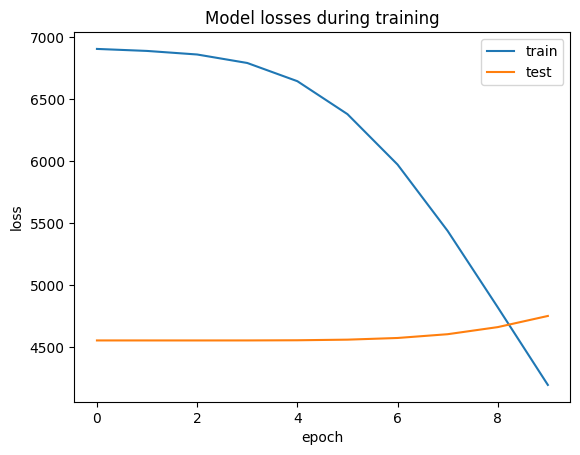

In [17]:
# Plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [18]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    retrieval_model.query_model
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          candidates_corpus_dataset.batch(100),
          candidates_corpus_dataset.batch(100).map(
              retrieval_model.candidate_model
          )
      )
  )
)

user_id = '42'
afinity_scores, movie_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]}")

2024-08-25 20:14:58.094162: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-25 20:14:58.109528: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-08-25 20:14:58.111189: W scann/utils/gmm_utils.cc:920] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-08-25 20:14:58.113960: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 4.36972ms.


Recommendations for user 42 using ScaNN: [b'210' b'740' b'1001' b'124' b'307']
